In [1]:
%load_ext autoreload
%autoreload 1

Adapted from:
* https://www.tensorflow.org/probability/examples/Linear_Mixed_Effects_Model_Variational_Inference

In [2]:
from beanmachine.tutorials.utils.radon import load_data

df = load_data()
df.head()

/root/micromamba/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


,county_index,county,floor,activity,log_activity,Uppm,log_Uppm
0,0,AITKIN,1,2.2,0.832909,0.502054,-0.689048
1,0,AITKIN,0,2.2,0.832909,0.502054,-0.689048
2,0,AITKIN,0,2.9,1.098612,0.502054,-0.689048
3,0,AITKIN,0,1.0,0.095310,0.502054,-0.689048
4,1,ANOKA,0,2.8,1.064711,0.428565,-0.847313


There are two `floor`s with lots of data and many counties with little data.

<AxesSubplot:>

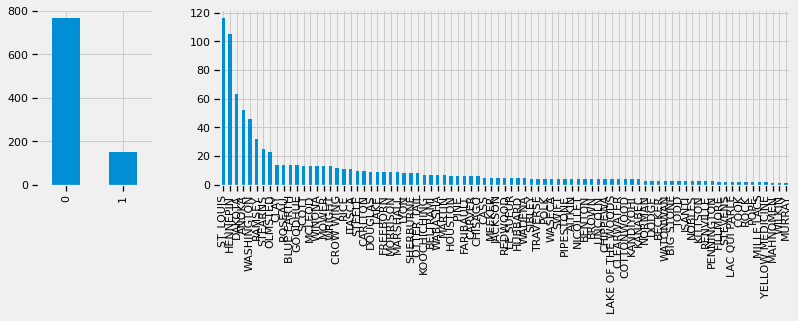

In [3]:
from matplotlib import pyplot as plt; plt.style.use('fivethirtyeight')
import seaborn as sns; sns.set_context('notebook')

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(12, 3))
df['floor'].value_counts().plot(kind='bar', ax=ax[0])
df['county'].value_counts().plot(kind='bar', ax=ax[1])

Since many counties have little data, to avoid overfitting county effects we will model it as a random effect within a GLMM:

$$\log \text{radon}_j \sim c + \text{floor\_effect}_j + \mathcal{N}(\text{county\_effect}_j, \text{county\_scale})$$

Note that the scale here is global across all counties and the random effect is normal; the [hierarchical linear mixed effects models](https://en.wikipedia.org/wiki/Hierarchical_generalized_linear_model) we will look at later will generalize this.

In [62]:
%aimport beanmachine.ppl

In [64]:
df.head()

,county_index,county,floor,activity,log_activity,Uppm,log_Uppm
0,0,AITKIN,1,2.2,0.832909,0.502054,-0.689048
1,0,AITKIN,0,2.2,0.832909,0.502054,-0.689048
2,0,AITKIN,0,2.9,1.098612,0.502054,-0.689048
3,0,AITKIN,0,1.0,0.095310,0.502054,-0.689048
4,1,ANOKA,0,2.8,1.064711,0.428565,-0.847313


In [65]:
import numpy as np

features = df[['county_index', 'floor']].astype(int)
labels = df[['log_activity']].astype(np.float32).values.flatten()

In [66]:
import beanmachine.ppl as bm
import torch
import torch.distributions as dist

floor = torch.tensor(features.floor.values)
county_index = torch.tensor(features.county_index.values)

@bm.random_variable
def county_scale():
    return dist.HalfNormal(scale=1.)

@bm.random_variable
def intercept():
    return dist.Normal(loc=0., scale=1.)

@bm.random_variable
def floor_weight():
    return dist.Normal(loc=0., scale=1.)

@bm.random_variable
def county_prior():
    return dist.Independent(dist.Normal(
        loc=torch.zeros(county_index.unique().numel()),
        scale=county_scale(),
    ), 1)


@bm.random_variable
def linear_response():
    fixed_effect = intercept() + floor_weight() * floor
    random_effect = torch.gather(county_prior(), 0, county_index)
    return dist.Independent(dist.Normal(
        loc=fixed_effect + random_effect,
        scale=1.,
    ), 1)

In [111]:
from torch.distributions import constraints
from torch.distributions.transforms import Transform
import torch.nn as nn
import torch.nn.functional as F

class SoftplusTransform(Transform):
    r"""
    Transform via the mapping :math:`y = \log(1 + \exp(x))`

    Source: https://discuss.pytorch.org/t/branching-for-numerical-stability/15763/4
    """
    domain = constraints.real
    codomain = constraints.positive
    bijective = True
    sign = +1

    def __init__(self):
        super().__init__()
        self.softplus = nn.Softplus()
        self.threshold = 20
        self.log_sigmoid = nn.LogSigmoid()

    def _call(self, x):
        return self.softplus(x)

    def _inverse(self, y):
        return torch.where(y>self.threshold, y, y.expm1().log())

    def log_abs_det_jacobian(self, x, y):
        return self.log_sigmoid(x)

@bm.param
def phi():
    return torch.tensor([
        0., 1.,
        0., 1.,
        0., 1.,
    ]).float()

@bm.random_variable
def q_county_scale():
    return dist.TransformedDistribution(dist.Normal(phi()[0], phi()[1].sigmoid()), [SoftplusTransform()])

@bm.random_variable
def q_intercept():
    return dist.Normal(phi()[2], phi()[3].sigmoid())

@bm.random_variable
def q_floor_weight():
    return dist.Normal(phi()[4], phi()[5].sigmoid())


# indexing was too hard, so I made another param
# NOTE: can we automate this or make it easier? as a beanstalk fixer?
@bm.param
def phi_county_prior():
    return torch.zeros(county_index.unique().numel())

@bm.random_variable
def q_county_prior():
    return dist.Independent(dist.Normal(
        loc=phi_county_prior(),
        scale=1.,
    ), 1)

In [91]:
%autoreload

In [108]:
from tqdm.auto import tqdm

vi = bm.VariationalInfer(
    queries_to_guides={
        county_prior(): q_county_prior(),
        floor_weight(): q_floor_weight(),
        intercept(): q_intercept(),
        county_scale(): q_county_scale(),
    },
    observations={
        linear_response(): torch.tensor(labels),
    },
    optimizer=lambda params: torch.optim.Adam(params, lr=1e-2),
)

num_steps = 3000
losses = torch.empty(num_steps)
for i in tqdm(range(num_steps)):
    loss, _ = vi.step()
    losses[i] = loss


  0%|          | 0/3000 [00:00<?, ?it/s]

<AxesSubplot:>

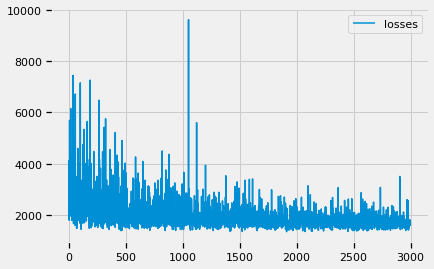

In [109]:
import pandas as pd

pd.DataFrame({
    "losses": losses.detach().numpy()
}).plot(kind='line')

In [93]:
world.get_variable(q_county_prior()).distribution.base_dist.loc

tensor([-0.5160, -0.7686, -0.2105,  0.2258,  0.0883, -0.0415,  0.7194,  0.6107,
        -0.3117, -0.2543,  0.2168,  0.1064, -0.2911,  0.5397, -0.3047, -0.1180,
        -0.1454, -0.1673,  0.2849,  0.3194,  0.3263, -0.6409, -0.1123,  0.6033,
         0.9261,  0.0404,  0.2337,  0.0349, -0.1542, -0.6156,  0.0722, -0.0722,
         0.3679,  0.1164, -0.3142,  1.0069, -0.7374,  0.2795,  0.1773,  0.6676,
         0.5728, -0.3851,  0.2874, -0.3631,  0.1891,  0.1339, -0.2968, -0.3332,
         0.5739,  0.4790,  0.3693,  0.4591, -0.7230, -0.2212, -0.2037,  0.1869,
        -0.5121,  0.0181,  0.0411,  0.0732, -0.1346,  0.7217,  0.3631,  0.1852,
        -0.3106,  0.4923, -0.1238, -0.7368, -0.0680, -0.3565,  0.1065,  0.3660,
         0.3151, -0.3012,  0.3415,  0.2831, -0.1112, -0.2315, -0.2575,  0.2124,
         1.0670, -0.3180,  0.0740,  0.4366,  0.2132], requires_grad=True)

In [94]:
world.get_variable(q_floor_weight()).distribution

Normal(loc: -0.6385678052902222, scale: 0.08725188672542572)

In [95]:
world.get_variable(q_intercept()).distribution

Normal(loc: 1.4306796789169312, scale: 0.0716254711151123)

We have to Monte-Carlo approximate `q_scale_prior` since closed form means are not always available after pushforward (ie `TransformedDistribution.mean` is unimplemented)

In [96]:
scale_prior_sample = world.get_variable(q_county_scale()).distribution.sample((100000,))
print(
    scale_prior_sample.mean(),
    scale_prior_sample.var(),
)

tensor(0.9534) tensor(0.0006)
